Import the needed packages and ml modules 

In [1]:
import numpy as np
import pandas as pd

import xarray as xr
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import folium
import folium.plugins
import pandas as pd
import xarray as xr
import branca
import branca.colormap as cm

Read offshore and onshore data

In [2]:
d_array = np.memmap('../data/processed/d_CT.dat',
                mode='r+',
                dtype=float,
                shape=(1197, 2224, 912))

t_array = np.memmap('../data/processed/t_CT.dat',
                mode='r+',
                dtype=float,
                shape=(1197, 9, 480))

red_d_array = np.memmap('../data/processed/dflat_CT.dat',
                         mode='r+',
                         dtype=float,
                         shape=(1197, 418877))

Autoencoder model for offshore to onshore time series

In [3]:
# input data
data_in = t_array[:int(len(red_d_array)*0.65),:]
test_data_in = t_array[int(len(red_d_array)*0.65):,:]
data_out = red_d_array[:int(len(red_d_array)*0.65),:]
test_data_out = red_d_array[int(len(red_d_array)*0.65):,:]

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, ninputs=5,t_len = 480, ch_list = [32,64,96], zdim = 50 ):
        super(Autoencoder, self).__init__()
        # more channels mean more fine details, more resolution 
        # less channel and layers less likely to overfit so better maximas and minimas
        # more accuracy but slower and more memory and data needed to train
        self.ch_list = ch_list

        # define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(ninputs, ch_list[0], kernel_size=3, padding=1),   
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,nn.AvgPool1d(kernel_size=2, stride=2),         
            nn.Conv1d(ch_list[0], ch_list[1], kernel_size=3, padding=1),   
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,nn.AvgPool1d(kernel_size=2, stride=2),         
            nn.Conv1d(ch_list[1], ch_list[2], kernel_size=3, padding=1), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.1),nn.Flatten(),
            nn.Linear(int(t_len*self.ch_list[-1]/(2**len(ch_list))), zdim),          

        )
        # define decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(zdim,int(t_len*self.ch_list[-1]/(2**len(ch_list)))),
            nn.Unflatten(1, (ch_list[-1], int(t_len/(2**len(ch_list))))) ,
            nn.ConvTranspose1d(ch_list[2], ch_list[1], kernel_size=4, padding=1, stride= 2),  
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[1], ch_list[0], kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[0], ninputs, kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
        )

        # self.latenspace =nn.Sequential(
        #     nn.Linear(int(t_len*self.ch_list[-1]/(2**len(ch_list))), zdim), # 96 x 60 ---> 50 Latent variables #divide by 4 for 2 layers and 8 for three layers
        #     nn.Linear(zdim,int(t_len*self.ch_list[-1]/(2**len(ch_list)))) # 10 Latent variables ---> 96 x 60 )
        # )
    def encode(self, x):
        x = self.encoder(x)
        # x = x.view(x.size(0), -1) # flatten the output
        # print(x.shape)
        return x
    
    def decode(self, x):
        # x = x.view(x.size(0), self.ch_list[-1], -1) # unflatten the output
        x = self.decoder(x)
        # print(x.shape)
        return x
    
    def forward(self, x):
        x = self.encode(x)  
        # x = self.latenspace(x)
        x = self.decode(x)
        return x

In [8]:
np.random.seed(0)
torch.random.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

offshore_model = torch.load(f"./../model/CT/out/model_offshore_ch_[64, 128, 256]_epoch_1000")
onshore_model = torch.load(f"./../model/CT/out/model_onshore_zdim_[64, 64]_epoch_2600.pt")


In [9]:
class mi_Net(nn.Module):
    def __init__(self, layers, **kwargs):
        super(mi_Net, self).__init__()

        # Pretrained offshore 
        self.offshore_encoder = offshore_model.encoder
        for i, layer in enumerate(self.offshore_encoder):
            if i < len(self.offshore_encoder) - 1: #all layers except last
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                for param in layer.parameters(): #last layer
                    param.requires_grad = True

        # Interface
        if layers == 1:
            self.connect = nn.Sequential(
                                nn.Linear(
                                    in_features=64, out_features=64
                                ),
                                nn.ReLU(),
        ) 
        elif layers == 2:    
            self.connect = nn.Sequential(
                                    nn.Linear(
                                        in_features=64, out_features=64
                                    ),
                                    nn.LeakyReLU(inplace=True),
                                    nn.Linear(
                                        in_features=64, out_features=64
                                    ),
                                    nn.LeakyReLU(inplace=True),
            )
        #Pretrained onshore model
        self.onshore_decoder = onshore_model.decoder 
        for i, layer in enumerate(self.onshore_decoder):
            if i < 1:
                for param in layer.parameters(): #first layer
                    param.requires_grad = True
            else:
                for param in layer.parameters(): #all layers except first
                    param.requires_grad = False
      
    def forward(self, x):
        x = self.offshore_encoder(x)
        x = self.connect(x)
        x = self.onshore_decoder(x)
        return x

def trainAE(batch_size,nepochs,lr,layers): 
    # Create PyTorch DataLoader objects
    #input-offshore, 
    train_dataset_in = torch.utils.data.TensorDataset(torch.Tensor(data_in[0:int(len(data_in)*0.99)]))   
    train_loader_in = torch.utils.data.DataLoader(train_dataset_in, batch_size=batch_size, shuffle=False)
    val_dataset_in = torch.utils.data.TensorDataset(torch.Tensor(data_in[int(len(data_in)*0.99):]))
    val_loader_in = torch.utils.data.DataLoader(val_dataset_in, batch_size=batch_size, shuffle=False)
    test_dataset_in = torch.utils.data.TensorDataset(torch.Tensor(test_data_in))
    test_loader_in = torch.utils.data.DataLoader(test_dataset_in, batch_size=batch_size, shuffle=False)
    # output-onshore
    train_dataset_out = torch.utils.data.TensorDataset(torch.Tensor(data_out[0:int(len(data_out)*0.99)]))   
    train_loader_out = torch.utils.data.DataLoader(train_dataset_out, batch_size=batch_size, shuffle=False)
    val_dataset_out = torch.utils.data.TensorDataset(torch.Tensor(data_out[int(len(data_out)*0.99):]))
    val_loader_out = torch.utils.data.DataLoader(val_dataset_out, batch_size=batch_size, shuffle=False)
    test_dataset_out = torch.utils.data.TensorDataset(torch.Tensor(test_data_out))
    test_loader_out = torch.utils.data.DataLoader(test_dataset_out, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and loss function
    model = mi_Net(layers=layers)
    model.to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    t_epoch_losses = []
    es_epoch_losses = []
    test_epoch_losses = []

    # Train model
    for epoch in range(nepochs):
        train_loss = 0
        es_losses = 0
        test_losses = 0
        for batch_data_in,batch_data_out in zip(train_loader_in,train_loader_out):
            optimizer.zero_grad()
            batch_data_in = batch_data_in[0].to('cuda')
            batch_data_out = batch_data_out[0].to('cuda')
            recon_data = model(batch_data_in)
            loss = criterion(recon_data, batch_data_out)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
                
        for batch_data_in,batch_data_out in zip(val_loader_in,val_loader_out):
            batch_data_in = batch_data_in[0].to('cuda')
            batch_data_out = batch_data_out[0].to('cuda')
            recon_data = model(batch_data_in)
            vloss = criterion(recon_data, batch_data_out)
            es_losses += vloss.item()

        for batch_data_in,batch_data_out in zip(test_loader_in,test_loader_out):
            batch_data_in = batch_data_in[0].to('cuda')
            batch_data_out = batch_data_out[0].to('cuda')
            recon_data = model(batch_data_in)
            tloss = criterion(recon_data, batch_data_out)
            test_losses += tloss.item()

        print(f"NoFold,epoch:{epoch},training loss: {train_loss / len(train_loader_in):.5f},val loss: {es_losses / len(val_loader_in):.5f},test loss:{test_losses / len(test_loader_in):.5f} ", end="\r")
        
        t_epoch_losses.append(train_loss / len(train_loader_in))
        es_epoch_losses.append(es_losses / len(val_loader_in))
        test_epoch_losses.append(test_losses / len(test_loader_in))

        #save model at every 200th epoch
        if epoch % 200 == 0:
            torch.save(model, f"./../model/CT/out/model_onshore_layers_{layers}_epoch_{epoch}.pt")
        
        #plot training/val loss
        plt.plot(t_epoch_losses, color='blue')
        plt.plot(es_epoch_losses, color='red')
        plt.plot(test_epoch_losses, color='green')
        plt.title(f"Training loss for Nofold")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.yscale('log')
        plt.legend(['train', 'val', 'test'], loc='upper right')
        plt.savefig(f"./../model/CT/plot/off2onshore_Pretrained_layers{layers}.png")   
        # plt.clf()
   
    #append z info + train,val,test loss to file as new line
    with open(f"./../model/CT/out/model_off2onshore_loss.txt", "a") as text_file:
        text_file.write(f"layers: {layers}, train loss: {t_epoch_losses[-1]}, val loss: {es_epoch_losses[-1]}, test loss: {test_losses / len(test_loader_in):.5f}\n")
    text_file.close()   


KeyboardInterrupt: 

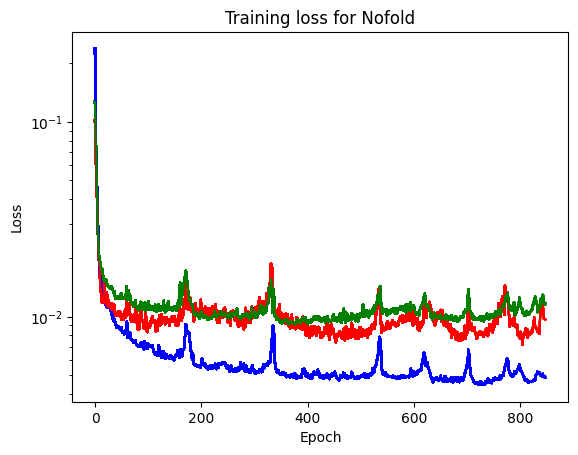

In [10]:
# y = data.shape[1] 
# x = data.shape[2]
#64 128 256
#64 32

# ninputs = 5
# t_len = 480
# xy= data_out.shape[1]
batch_size = 20
num_epochs = 4000
learning_rate = 0.0005
layers = 2

trainAE(batch_size,num_epochs,learning_rate,layers)


test loss: 0.00897


Text(0, 0.5, 'Reconstructed')

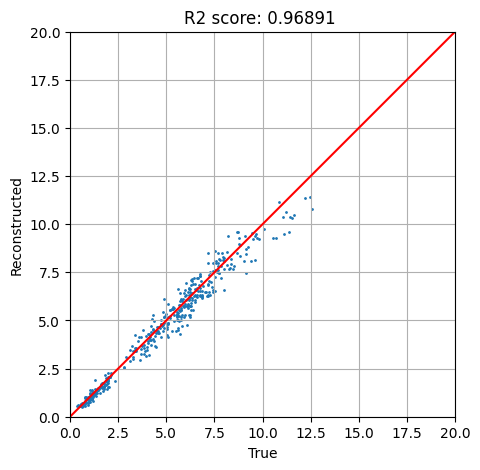

In [15]:
#read model from file for testing
model = torch.load(f"./../model/CT/out/model_onshore_layers_2_epoch_400.pt")
model.eval()
# summary(model, (ninputs,t_len,xy))

# Test model for final evaluation
predic = np.zeros(test_data_out.shape)
criterion = nn.MSELoss()  
test_dataset_in = torch.utils.data.TensorDataset(torch.Tensor(test_data_in))
test_loader_in = torch.utils.data.DataLoader(test_dataset_in, batch_size=batch_size, shuffle=False)
test_dataset_out = torch.utils.data.TensorDataset(torch.Tensor(test_data_out))
test_loader_out = torch.utils.data.DataLoader(test_dataset_out, batch_size=batch_size, shuffle=False)

# Test model
with torch.no_grad():
    test_loss = 0
    for batch_idx,(batch_data_in,batch_data_out) in enumerate(zip(test_loader_in,test_loader_out)):
        batch_data_in = batch_data_in[0].to('cuda')
        batch_data_out = batch_data_out[0].to('cuda')
        recon_data = model(batch_data_in)
        loss = criterion(recon_data, batch_data_out)
        test_loss += loss.item()
        predic[batch_idx*batch_size:(batch_idx+1)*batch_size] = recon_data.cpu().numpy()
    print(f"test loss: {test_loss / len(test_loader_in):.5f}")

# Plot results max height for all events
test_max = np.max(test_data_out,axis=(1))
recon_max = np.max(predic,axis=(1))

plt.figure(figsize=(5, 5))
plt.scatter(test_max, recon_max, s=1)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.title(f"R2 score: {r2_score(test_max, recon_max):.5f} ")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')


In [18]:
all_ids = np.loadtxt('../data/events/shuffled_events_CT.txt', dtype='str',skiprows=0)
test_ids = all_ids[int(len(all_ids)*0.65):]
eve_info = pd.read_csv('../data/info/about_alleve1212_PS.txt', sep='\t')

#check performance per event
eve_perf = []
for eve_no,eve in enumerate(test_ids):
    eve_perf.append([eve_no,r2_score(test_data_out[eve_no,:], predic[eve_no,:]),np.count_nonzero(test_data_out[eve_no,:])])

#count of events less than 
eve_perf = np.array(eve_perf)
print(eve_perf[eve_perf[:,1]<0.9].shape[0])
print(eve_perf[eve_perf[:,1]<0.9])
#411,382,223
eve_no = 349 
eve = test_ids[eve_no]

39
[[ 0.00000000e+00  8.50741565e-01  3.12700000e+03]
 [ 1.90000000e+01  8.83108060e-01  2.79400000e+03]
 [ 2.10000000e+01  7.76827996e-01  5.63400000e+03]
 [ 3.10000000e+01  8.32576271e-01  2.75800000e+03]
 [ 3.40000000e+01  7.77554933e-01  2.39600000e+03]
 [ 5.20000000e+01  5.76244855e-01  5.01700000e+03]
 [ 5.90000000e+01  8.51877020e-01  2.43200000e+03]
 [ 7.60000000e+01  8.88188202e-01  7.67000000e+03]
 [ 9.10000000e+01  8.65083001e-01  2.67300000e+03]
 [ 9.20000000e+01  7.52780638e-01  6.37600000e+03]
 [ 9.30000000e+01 -2.60283550e-01  1.71200000e+03]
 [ 9.70000000e+01  8.91829764e-01  4.92800000e+03]
 [ 1.20000000e+02  8.88613125e-01  7.33900000e+03]
 [ 1.28000000e+02  8.25429831e-01  2.71200000e+03]
 [ 1.31000000e+02  8.81869484e-01  4.91900000e+03]
 [ 1.39000000e+02  4.74245910e-01  2.07600000e+03]
 [ 1.50000000e+02  7.65092471e-01  2.55200000e+03]
 [ 1.54000000e+02  8.96968921e-01  3.55700000e+03]
 [ 1.66000000e+02  8.86388400e-01  5.40300000e+03]
 [ 1.76000000e+02 -1.2811536

In [33]:
#93,200,139,267,314
eve_no = 242 
eve = test_ids[eve_no]
#count number of grids with max height > 0.5
test_05 = np.count_nonzero(test_data_out[eve_no, :] > 0.05)
recon_05 = np.count_nonzero(predic[eve_no, :] > 0.05)
print(f"test_05: {test_05}, recon_05: {recon_05}")

test_05: 323571, recon_05: 311096


-0.29037052392959595


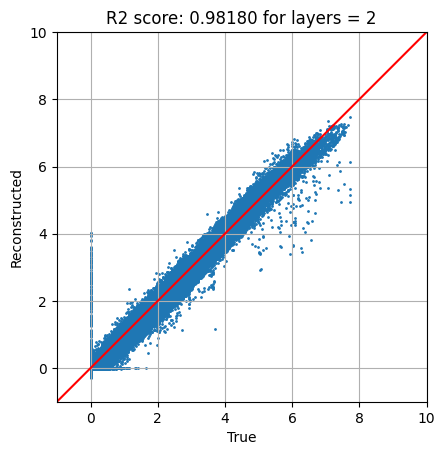

E01548N3896E01854N3659-PS-Str_PYes_Var-M861_E01734N3775_S001



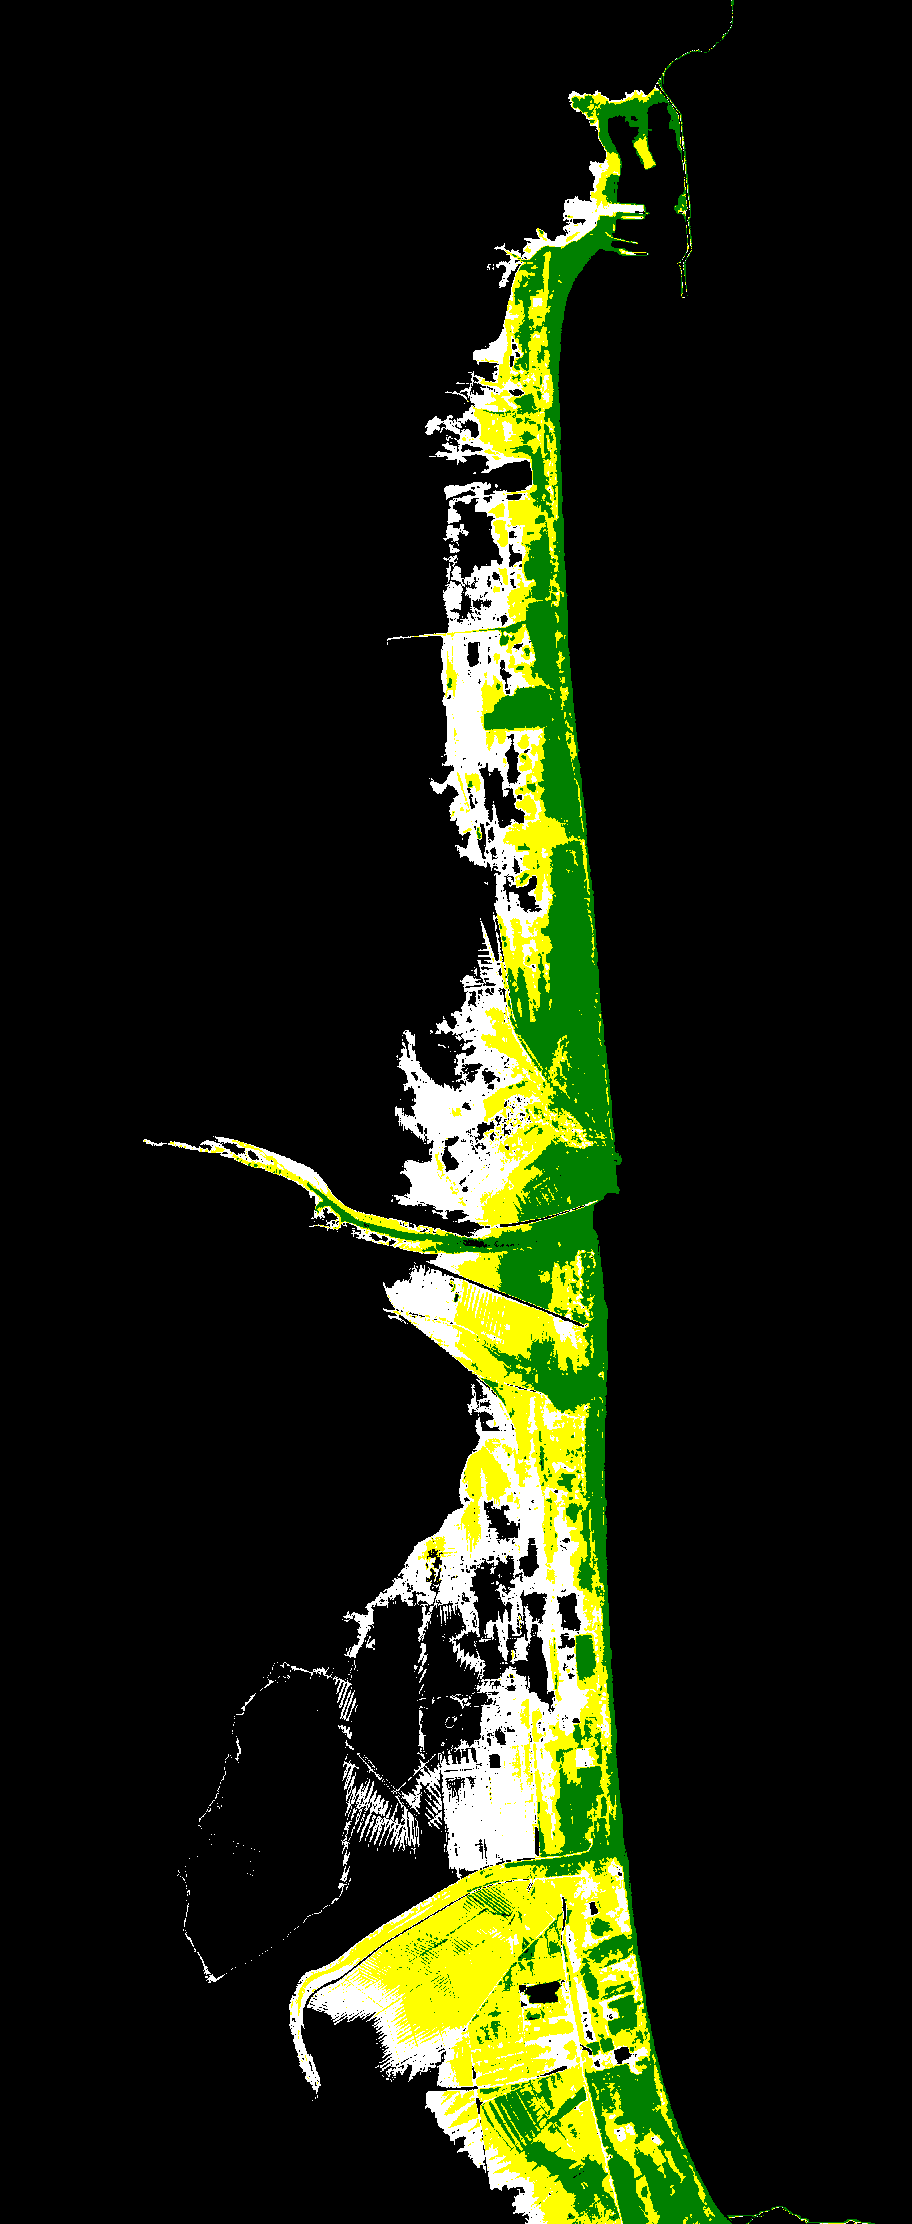
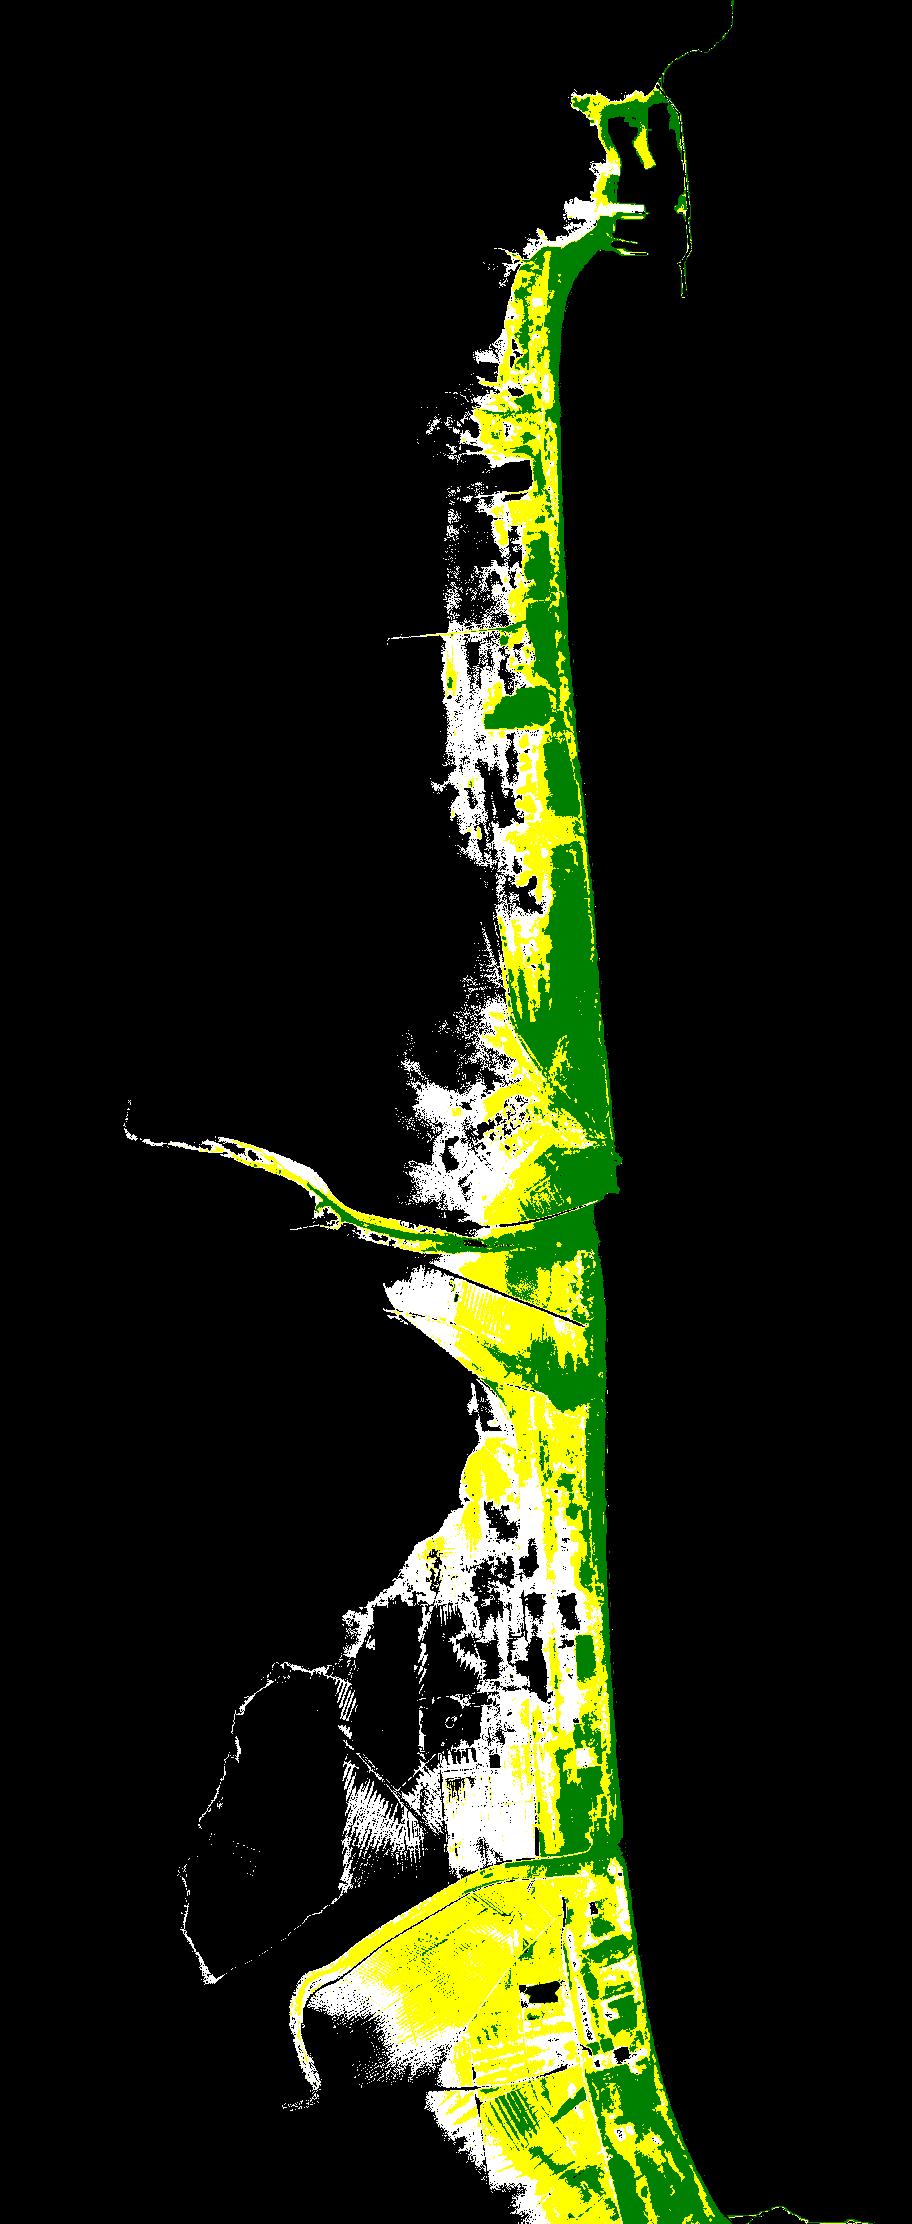
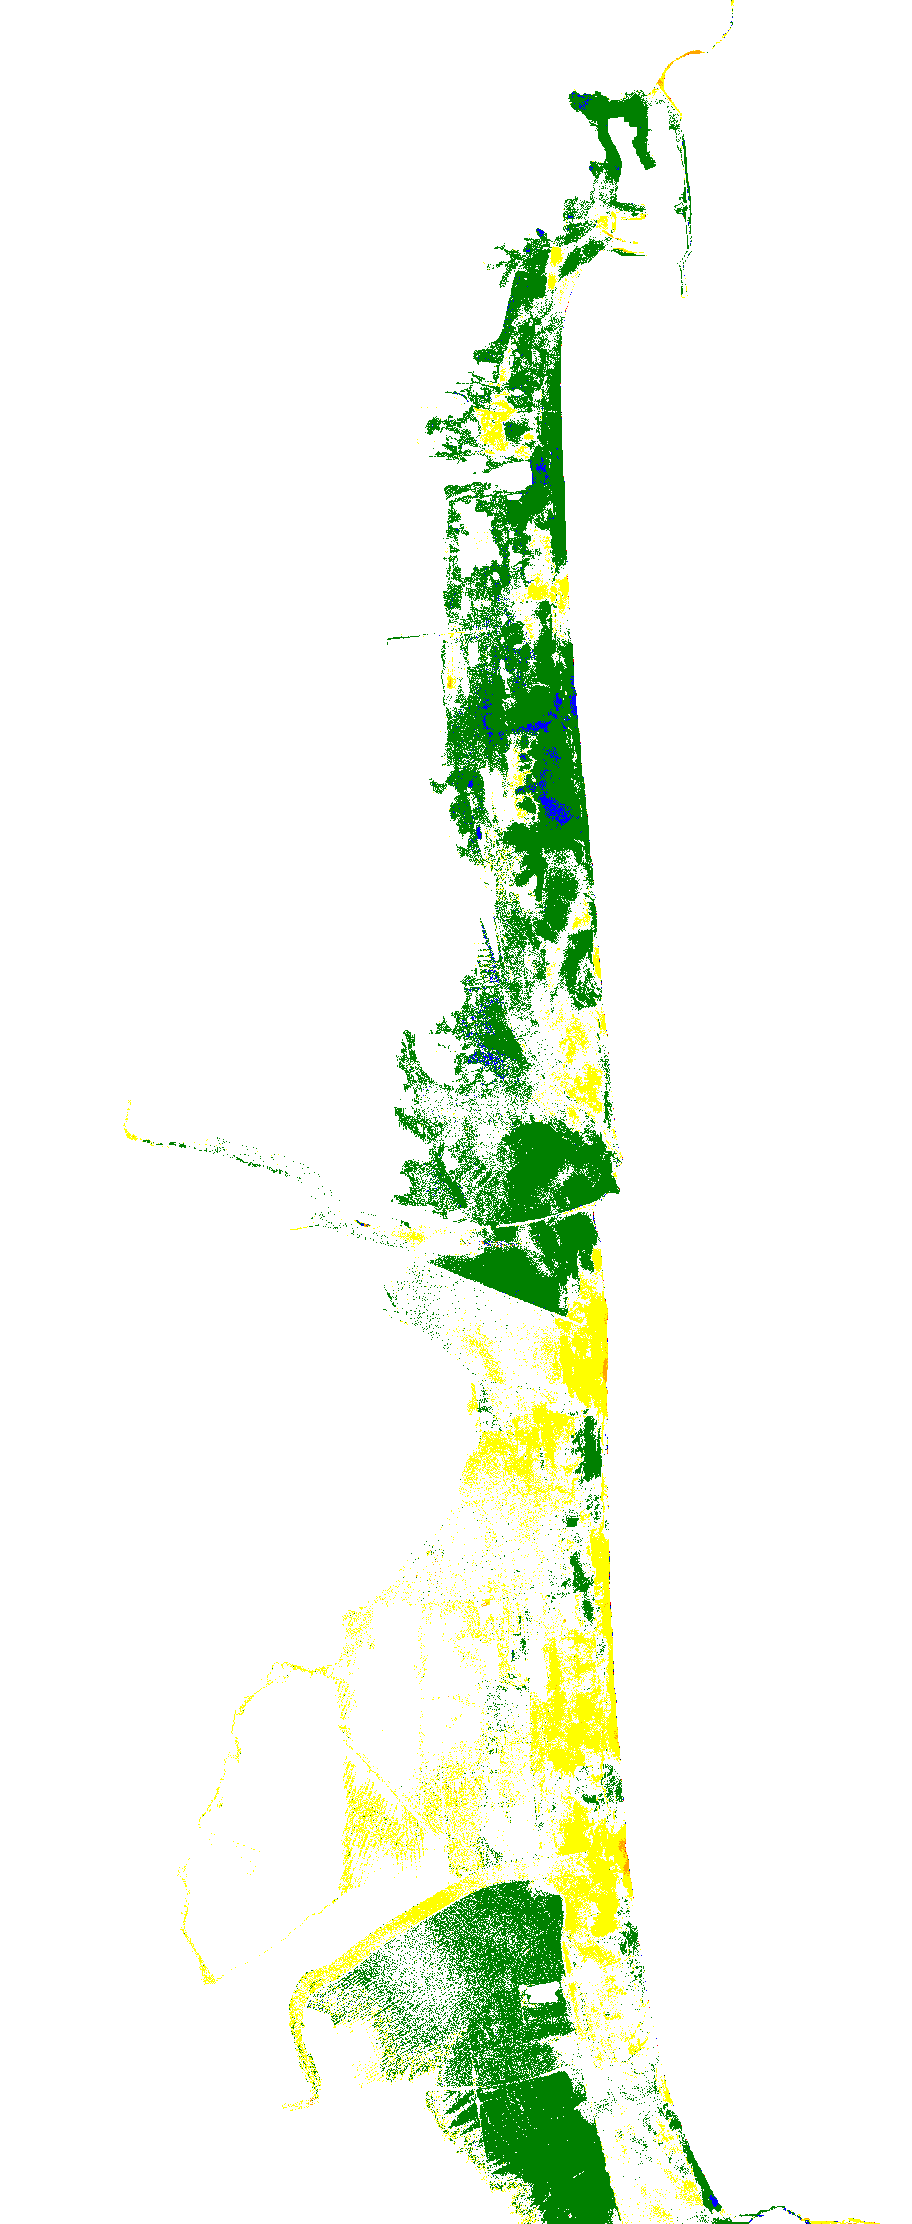

In [34]:
# Plot results max depth and error for one event with basemap around sicily

#grid map
error2fill = np.zeros(d_array.shape[1:])
depth2fill = np.zeros(d_array.shape[1:])

print(min(predic[eve_no,:]))

zero_mask = np.load('../data/processed/CT_zero_mask.npy')
error2fill[~zero_mask] = test_data_out[eve_no, :] - predic[eve_no, :]
depth2fill[~zero_mask] = predic[eve_no,:]

plt.scatter(test_data_out[eve_no,:], predic[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(test_data_out[eve_no,:], predic[eve_no,:]):.5f} for layers = {layers}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()

sim_dir = '../data/simu/PS_manning003/'
# Load the points file
data_pts = np.loadtxt('../resources/raw/pois_eastern_sicily_2km.txt', dtype=str)
id_pts = data_pts[:, 0]
lon_pts = data_pts[:, 1].astype(float)
lat_pts = data_pts[:, 2].astype(float)
z_pts = data_pts[:, 3].astype(float)

ds_ts = xr.open_dataset(os.path.join(sim_dir,eve,'grid0_ts.nc')) #gridts file
ds_grids_CT = xr.open_dataset(os.path.join(sim_dir,eve,'CT_flowdepth.nc')) #gridts file
ds_grids_SR = xr.open_dataset(os.path.join(sim_dir,eve,'SR_flowdepth.nc')) #gridts file

# Create a Folium map centered on the data's extent
m = folium.Map(location=[np.mean(lat_pts),np.mean(lon_pts)], zoom_start=10)
m = folium.Map(location=[37.404,15.08], zoom_start=11)
# Basemaps
folium.TileLayer(tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True,
        show = False).add_to(m)

# Create a feature group for the offshore points 
fg_pts = folium.FeatureGroup(name='Offshore Points Txt').add_to(m)
# fg_ptsNC = folium.FeatureGroup(name='Offshore Points NetCDF').add_to(m)
fg_gridnc_SR = folium.FeatureGroup(name='SR Grid NetCDF').add_to(m)
fg_gridnc_CT = folium.FeatureGroup(name='CT Grid NetCDF').add_to(m)
fg_gridnc_ML_d = folium.FeatureGroup(name='ML Grid Depth NetCDF').add_to(m)
fg_gridnc_ML_e = folium.FeatureGroup(name='ML Grid Error NetCDF').add_to(m)

#add eq lat lon point
print(eve)

# E01548N3896E01854N3659-PS-Str_PYes_Hom-M861_E01673N3781_S005
lon = float(str(eve).split('_')[-2][1:5])/10
lat = float(str(eve).split('_')[-2][7:11])/100

folium.CircleMarker(location=[lat,lon],radius = 15,color='red',fill_color = 'red').add_to(m)

# Add a marker for each point with a tooltip showing its id
for id, lat, lon,z in zip(id_pts, lat_pts, lon_pts, z_pts):
    info = f"ID:{id}, Depth: {z} "  # Create tooltip string
    folium.Marker(location=[lat, lon],
                  tooltip=info,
                  icon=folium.Icon(color='blue', icon='')).add_to(fg_pts)

df_ts = pd.DataFrame({'lat':ds_ts.latitude.values.astype(float),
                      'lon':ds_ts.longitude.values.astype(float),
                      'z':ds_ts.deformed_bathy.values.astype(float)})

# for i,row in df_ts.iterrows():
#     info = f"ID:{i}, Depth: {row['z']} "  # Create tooltip string
#     folium.Marker(location=[row['lat'], row['lon']],
#                   tooltip=info,
#                  icon=folium.Icon(color='red', icon='')).add_to(fg_ptsNC)

# Add grid netcdfs  
# #CATANIA  
# data2plot = ds_grids_CT#.isel(time=0)
# data = np.flipud(data2plot.z.values.astype(float))

# lon,lat = np.meshgrid(data2plot.lon.values.astype(float),
#                       data2plot.lat.values.astype(float))

# ext = [[lat.min(),lon.min()],
#          [lat.max(),lon.max()]]
# cm_function = matplotlib.cm.get_cmap('coolwarm', 5)
# norm = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data)) 

# folium.raster_layers.ImageOverlay(cm_function(norm),ext,opacity=0.5).add_to(fg_gridnc_CT)
 #SIRACUSA
data2plot = ds_grids_CT#.isel(time=0)
data = np.flipud(data2plot.z.values.astype(float))
data[data <= 0.1] = np.nan
lon,lat = np.meshgrid(data2plot.lon.values.astype(float),
                      data2plot.lat.values.astype(float))

ext = [[lat.min(),lon.min()],
         [lat.max(),lon.max()]]

# norm = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data)) 


#plot depth and error
error2fill = np.flipud(error2fill)
depth2fill = np.flipud(depth2fill)

#set 0 values to nan
# error2fill[depth2fill <= 0.1] = np.nan
depth2fill[depth2fill <= 0.1] = np.nan
# normd = (depth2fill - np.nanmin(depth2fill)) / (np.nanmax(depth2fill) - np.nanmin(depth2fill)) 

#map error values interval_split to link colors
cmap = matplotlib.colors.ListedColormap(["red","orange","yellow","white" ,"green", "blue","black"])
interval_split = [-99,-2,-0.5, -0.1, 0.1, .5, 2, 99]
norme = matplotlib.colors.BoundaryNorm(interval_split, cmap.N)
error2fill = norme(error2fill)

#map depth values interval_split to link colors
dmap = matplotlib.colors.ListedColormap(["red","orange","white","yellow","green", "blue","black"])
depth_split = [-99, 0.05, 0.1, 1,2, 5, 99]
normd = matplotlib.colors.BoundaryNorm(depth_split, dmap.N)
depth2fill = normd(depth2fill)
norm = normd(data)
folium.raster_layers.ImageOverlay(dmap(norm),ext,opacity=0.8,interactive=True).add_to(fg_gridnc_CT)
folium.raster_layers.ImageOverlay(cmap(error2fill),ext,opacity=0.8,interactive=True).add_to(fg_gridnc_ML_e)
folium.raster_layers.ImageOverlay(dmap(depth2fill),ext,opacity=0.8,interactive=True).add_to(fg_gridnc_ML_d)
# #save matplotlib colormap and as FloatImage to map
# fig,ax = plt.subplots(figsize=(2,3))
# plt.colorbar(plt.pcolormesh(grid2fill,cmap=cmap),ax=ax)
# ax.remove()
# plt.savefig('./../resources/gis/html/colormap.png',bbox_inches='tight')
# folium.plugins.FloatImage('./../resources/gis/html/colormap.png', bottom=1, left=1).add_to(m)

# Add a layer control to turn on/off the feature groups
folium.LayerControl().add_to(m)
folium.plugins.MousePosition().add_to(m)


#save as html
#m.save('./../resources/gis/html/event_example.html')
m